In [2]:
%load_ext autoreload
%autoreload 2
import os

from  partie1 import GRUEncoderGD, GRUDecoderGD
from  partie1 import GRUEncoderDG, GRUDecoderDG
from partie1 import TensorProductEncoder
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchmetrics.classification import Accuracy
import numpy as np
import torch.optim as optim

/home/baptiste/micromamba/envs/cours/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils

In [3]:
input_size = 10
output_size = 10
batch_size = 16
seq_len = 10
epochs = 10000
learning_rate = 0.001

device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
precision= Accuracy(task="multiclass", num_classes=input_size).to(device) 

def generate_data(batch_size, seq_len, input_size):
    '''
    input_size : pour la plage de valeur 
    '''
    data = torch.randint(0, input_size, (batch_size, seq_len))  # fillers
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # rôles
    return data, roles

def plot_tensors(tensor1, tensor2, labels=("Tensor 1", "Tensor 2")):

    tensor1 = tensor1.flatten()
    tensor2 = tensor2.flatten()
    x_indices = range(len(tensor1))


    plt.figure(figsize=(10, 6))
    plt.plot(x_indices, tensor1.detach().numpy(), label=labels[0], marker='o')
    plt.plot(x_indices, tensor2.detach().numpy(), label=labels[1], marker='x')

    plt.title("Comparaison des valeurs des tenseur en fonction de l'indice")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# Train 

On entraîne les modèles en choisissant les paramètres optimaux trouvés par grid search à savoir :
- emb_size = 8
- hidden_size = 64
- num_layer = 5



## Gauche droite

In [20]:
num_layers = 5
emb_size = 8
hidden_size = 64


    

encoder = GRUEncoderGD(input_size, emb_size, hidden_size, num_layers=num_layers).to(device)
decoder = GRUDecoderGD(emb_size, hidden_size, output_size, num_layers=num_layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

losses = []
accuracies = []


for epoch in range(epochs):
    data , _ = generate_data(batch_size, seq_len, input_size)
    data = data.to(device)
    

    _, hidden = encoder(data)
    hidden = hidden.to(device)
    # print(hidden.shape)
    hidden = hidden[-1].unsqueeze(0).repeat(num_layers, 1, 1) 
    # on fait ca pour ne garder que la sortie de la couche finale et la copier pour avoir le bon nombre de couches pour le décodeur
    # si on met une seule couche dans le décodeur ca bug et on veut pas la suite de couches différentes sinon on peut pas l'utiliser avec le tpdn

    # print(hidden.shape)

    reconstructed_x = decoder(hidden, seq_len) #.argmax(dim=1) pour la loss on prend les logits et pas les classes directement

    loss = criterion(reconstructed_x.view(-1, output_size), data.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    accuracy = precision(reconstructed_x.argmax(dim=-1), data)
    losses.append(loss.item())
    accuracies.append(accuracy.cpu())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy*100:.2f}%")



torch.save(encoder, f"./models/final/GD/gru_enc_emb{emb_size}_hid{hidden_size}_layer{num_layers}.pth")
torch.save(decoder, f"./models/final/GD/gru_dec_emb{emb_size}_hid{hidden_size}_layer{num_layers}.pth")

fig, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(range(epochs), losses, color='tab:blue', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:orange')
ax2.plot(range(epochs), accuracies, color='tab:orange', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title(f'Loss and Accuracy (emb={emb_size}, hid={hidden_size})')
plt.savefig(f"./resultats/final/GD/training_gru_emb{emb_size}_hid{hidden_size}.png")
plt.show()
plt.close()



Epoch [10/10000], Loss: 2.3020, Accuracy: 10.62%
Epoch [20/10000], Loss: 2.2983, Accuracy: 13.12%
Epoch [30/10000], Loss: 2.2769, Accuracy: 12.50%
Epoch [40/10000], Loss: 2.2140, Accuracy: 15.00%
Epoch [50/10000], Loss: 2.2325, Accuracy: 16.88%
Epoch [60/10000], Loss: 2.2391, Accuracy: 13.75%
Epoch [70/10000], Loss: 2.1970, Accuracy: 18.12%
Epoch [80/10000], Loss: 2.1844, Accuracy: 16.88%
Epoch [90/10000], Loss: 2.1563, Accuracy: 18.12%
Epoch [100/10000], Loss: 2.1601, Accuracy: 20.62%
Epoch [110/10000], Loss: 2.1414, Accuracy: 21.25%
Epoch [120/10000], Loss: 2.1069, Accuracy: 18.12%
Epoch [130/10000], Loss: 2.0969, Accuracy: 24.38%
Epoch [140/10000], Loss: 2.1202, Accuracy: 25.62%
Epoch [150/10000], Loss: 2.1131, Accuracy: 18.12%
Epoch [160/10000], Loss: 2.1259, Accuracy: 18.12%
Epoch [170/10000], Loss: 2.0761, Accuracy: 26.88%
Epoch [180/10000], Loss: 2.1109, Accuracy: 23.12%
Epoch [190/10000], Loss: 2.0616, Accuracy: 23.12%
Epoch [200/10000], Loss: 2.0690, Accuracy: 24.38%
Epoch [21

In [4]:

input_size = 10
emb_size = 8
hidden_size = 64

output_size = 10
num_layers = 5
batch_size = 16
seq_len = 10
epochs = 20000
learning_rate = 0.001

emb_size_tpdn = 32



encoder = torch.load("./models/final/GD/gru_enc_emb8_hid64_layer5.pth")



seq_len_tensor = torch.tensor([seq_len]).to(device)

tpdnencoder = TensorProductEncoder(
    n_roles=seq_len,
    n_fillers=seq_len,
    filler_dim=emb_size_tpdn,
    role_dim=emb_size_tpdn,
    hidden_size=hidden_size
).to(device)

tpdnencoder.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(tpdnencoder.parameters(), lr=learning_rate)

losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    data, roles = generate_data(batch_size, seq_len, input_size)
    data = data.to(device)
    roles = roles.to(device)
    # roles = torch.flip(roles, dims=[1])

    with torch.no_grad():
        _, encoder_hidden = encoder(data)
    
    encoder_hidden = encoder_hidden[-1, :, :]  
    tpdn_output = tpdnencoder(data, roles)[:, -1, :].to(device) 
    loss = criterion(tpdn_output, encoder_hidden)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 2000 == 0:  
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}")


torch.save(tpdnencoder, f"./models/final/TPDN/GD/tpdn_gru_emb{emb_size_tpdn}.pth")

plt.figure()
plt.plot(losses)
plt.yscale('log')
plt.title(f'Loss over Epochs (emb_size_tpdn={emb_size_tpdn})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(f"./resultats/final/TPDN/GD/loss_tpdn_emb{emb_size_tpdn}.png")
plt.plot()
plt.close()





/tmp/ipykernel_5566/3548805455.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load("./models/final/GD/gru_enc_emb8_hid64_layer5.pth")


Epoch [2000/20000], Loss: 0.029373
Epoch [4000/20000], Loss: 0.023099
Epoch [6000/20000], Loss: 0.015925
Epoch [8000/20000], Loss: 0.011413
Epoch [10000/20000], Loss: 0.015443
Epoch [12000/20000], Loss: 0.013540
Epoch [14000/20000], Loss: 0.011668
Epoch [16000/20000], Loss: 0.013086
Epoch [18000/20000], Loss: 0.014550
Epoch [20000/20000], Loss: 0.014220


## Droite Gauche

In [ ]:
num_layers = 5
emb_size = 8
hidden_size = 64


encoder = GRUEncoderDG(input_size, emb_size, hidden_size, num_layers=num_layers).to(device)
decoder = GRUDecoderDG(emb_size, hidden_size, output_size, num_layers=num_layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

losses = []
accuracies = []


for epoch in range(epochs):
    data , _ = generate_data(batch_size, seq_len, input_size)
    data = data.to(device)
    

    _, hidden = encoder(data)
    hidden = hidden.to(device)
    # print(hidden.shape)
    hidden = hidden[-1].unsqueeze(0).repeat(num_layers, 1, 1) 
    # on fait ca pour ne garder que la sortie de la couche finale et la copier pour avoir le bon nombre de couches pour le décodeur
    # si on met une seule couche dans le décodeur ca bug et on veut pas la suite de couches différentes sinon on peut pas l'utiliser avec le tpdn

    # print(hidden.shape)

    reconstructed_x = decoder(hidden, seq_len) #.argmax(dim=1) pour la loss on prend les logits et pas les classes directement

    loss = criterion(reconstructed_x.view(-1, output_size), data.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    accuracy = precision(reconstructed_x.argmax(dim=-1), data)
    losses.append(loss.item())
    accuracies.append(accuracy.cpu())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy*100:.2f}%")



torch.save(encoder, f"./models/final/DG/gru_enc_emb{emb_size}_hid{hidden_size}_layer{num_layers}.pth")
torch.save(decoder, f"./models/final/DG/gru_dec_emb{emb_size}_hid{hidden_size}_layer{num_layers}.pth")

fig, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(range(epochs), losses, color='tab:blue', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:orange')
ax2.plot(range(epochs), accuracies, color='tab:orange', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title(f'Loss and Accuracy (emb={emb_size}, hid={hidden_size})')
plt.savefig(f"./resultats/final/DG/training_gru_emb{emb_size}_hid{hidden_size}.png")
plt.show()
plt.close()

In [5]:

input_size = 10
emb_size = 8
hidden_size = 64

output_size = 10
num_layers = 5
batch_size = 16
seq_len = 10
epochs = 20000
learning_rate = 0.001

emb_size_tpdn = 32



encoder = torch.load("./models/final/DG/gru_enc_emb8_hid64_layer5.pth")



seq_len_tensor = torch.tensor([seq_len]).to(device)

tpdnencoder = TensorProductEncoder(
    n_roles=seq_len,
    n_fillers=seq_len,
    filler_dim=emb_size_tpdn,
    role_dim=emb_size_tpdn,
    hidden_size=hidden_size
).to(device)

tpdnencoder.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(tpdnencoder.parameters(), lr=learning_rate)

losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    data, roles = generate_data(batch_size, seq_len, input_size)
    data = data.to(device)
    roles = roles.to(device)
    roles = torch.flip(roles, dims=[1])

    with torch.no_grad():
        _, encoder_hidden = encoder(data)
    
    encoder_hidden = encoder_hidden[-1, :, :]  
    tpdn_output = tpdnencoder(data, roles)[:, -1, :].to(device) 
    loss = criterion(tpdn_output, encoder_hidden)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 2000 == 0:  
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}")


torch.save(tpdnencoder, f"./models/final/TPDN/DG/tpdn_gru_emb{emb_size_tpdn}.pth")

plt.figure()
plt.plot(losses)
plt.yscale('log')
plt.title(f'Loss over Epochs (emb_size_tpdn={emb_size_tpdn})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(f"./resultats/final/TPDN/DG/loss_tpdn_emb{emb_size_tpdn}.png")
plt.plot()
plt.close()



/tmp/ipykernel_5566/755403293.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load("./models/final/DG/gru_enc_emb8_hid64_layer5.pth")


Epoch [2000/20000], Loss: 0.013314
Epoch [4000/20000], Loss: 0.007916
Epoch [6000/20000], Loss: 0.005405
Epoch [8000/20000], Loss: 0.003999
Epoch [10000/20000], Loss: 0.003062
Epoch [12000/20000], Loss: 0.003405
Epoch [14000/20000], Loss: 0.003777
Epoch [16000/20000], Loss: 0.003440
Epoch [18000/20000], Loss: 0.003286
Epoch [20000/20000], Loss: 0.003388


# EVAL 

## Gauche droite

/tmp/ipykernel_5566/3042930527.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load( "./models/final/GD/gru_enc_emb8_hid64_layer5.pth").to(device)
/tmp/i

Loss moyenne : 0.013051333739887924
 Ecart type : 0.007192167694453471


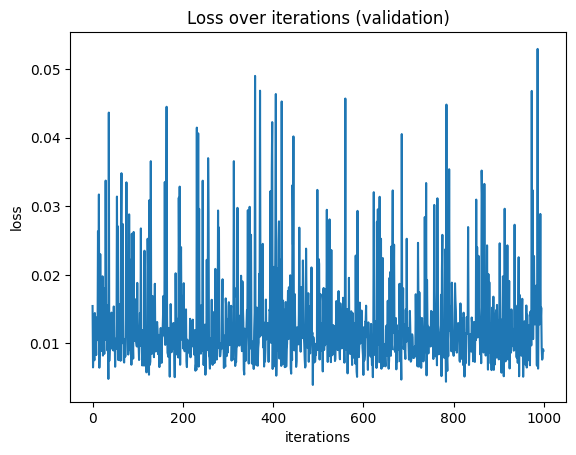

In [12]:
encoder = torch.load( "./models/final/GD/gru_enc_emb8_hid64_layer5.pth").to(device)
decoder = torch.load( "./models/final/GD/gru_dec_emb8_hid64_layer5.pth").to(device)

tpdn = torch.load("./models/final/TPDN/GD/tpdn_gru_emb32.pth").to(device)
    
criterion = nn.MSELoss()
loss_val = []
tpdn_outputs = []
rnn_outputs = []
for _ in range(1000) : 
    data , roles = generate_data(1, seq_len, input_size)
    data = data.to(device)
    roles = roles.to(device)
    rnn_out, rnn_hidden = encoder(data)
    tpdn_output= tpdn(data, roles)
    # tpdn_output = torch.tensor(tpdn_output)
    tpdn_hidden = tpdn_output[:,-1,:]
    loss_val.append(criterion(tpdn_output[:,-1,:].cpu(), rnn_out[:,-1,:].cpu()).item())
    tpdn_outputs.append(tpdn_output)
    rnn_outputs.append(rnn_out)

loss_val = np.array(loss_val)
plt.plot(loss_val)
plt.ylabel("loss")
plt.xlabel("iterations")
plt.title("Loss over iterations (validation)")

print("="*100)
print(f"Loss moyenne : {loss_val.mean()}")
print(f" Ecart type : {loss_val.std()}")
# print( rnn_out.shape)
# print(rnn_hidden.shape)
# print(tpdn_hidden.shape)
# print(tpdn_output.shape)



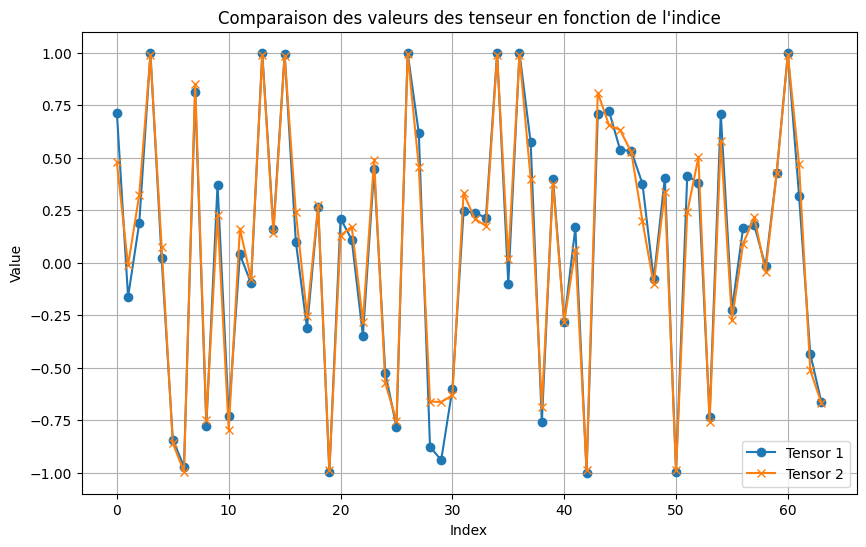

In [13]:

plot_tensors(rnn_hidden[-1].cpu(), tpdn_hidden.cpu())

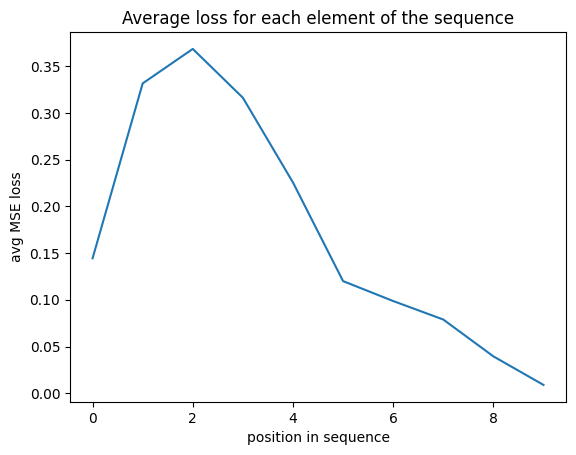

In [14]:
liste_error = []
error = {i : [] for i in range(tpdn_output.shape[1])}
# print( error)
criterion = nn.MSELoss()
for i in range(tpdn_output.shape[1]):
    error[i].append(criterion(tpdn_output[:,i,:].cpu(), rnn_out[:,i,:].cpu()).item())

error_avg  = {k: sum(v) / len(v) for k, v in error.items()}

avg = np.array([v for k, v in error_avg.items()])
plt.plot(avg)
plt.title("Average loss for each element of the sequence")
plt.xlabel("position in sequence")
plt.ylabel("avg MSE loss")
plt.show()

## Droite Gauche

/tmp/ipykernel_5566/406417598.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load( "./models/DG/gru_enc_emb8_hid64.pth").to(device)
/tmp/ipykernel_5566/

Loss moyenne : 0.008506738553522155
 Ecart type : 0.0025774287259457233


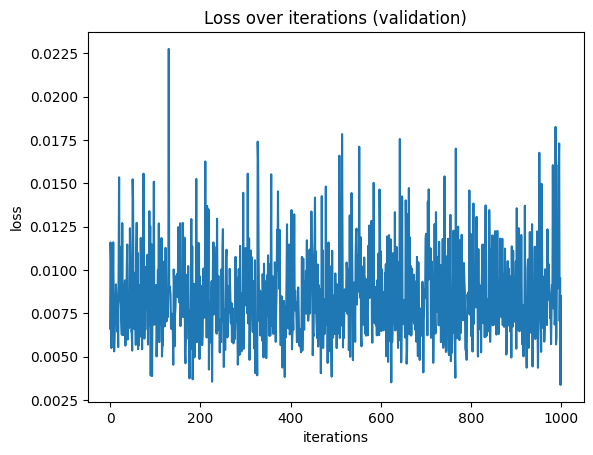

In [15]:
encoder = torch.load( "./models/DG/gru_enc_emb8_hid64.pth").to(device)
decoder = torch.load( "./models/DG/gru_dec_emb8_hid64.pth").to(device)

tpdn = torch.load("./models/TPDN/DG/tpdn_gru_emb32.pth").to(device)
    
criterion = nn.MSELoss()
loss_val = []
tpdn_outputs = []
rnn_outputs = []
for _ in range(1000) : 
    data , roles = generate_data(1, seq_len, input_size)
    data = data.to(device)
    roles = roles.to(device)
    roles = torch.flip(roles, dims=[1])
    rnn_out, rnn_hidden = encoder(data)
    tpdn_output= tpdn(data, roles)
    # tpdn_output = torch.tensor(tpdn_output)
    tpdn_hidden = tpdn_output[:,-1,:]
    loss_val.append(criterion(tpdn_output[:,-1,:].cpu(), rnn_out[:,-1,:].cpu()).item())
    tpdn_outputs.append(tpdn_output)
    rnn_outputs.append(rnn_out)

loss_val = np.array(loss_val)
plt.plot(loss_val)
plt.ylabel("loss")
plt.xlabel("iterations")
plt.title("Loss over iterations (validation)")

print("="*100)
print(f"Loss moyenne : {loss_val.mean()}")
print(f" Ecart type : {loss_val.std()}")

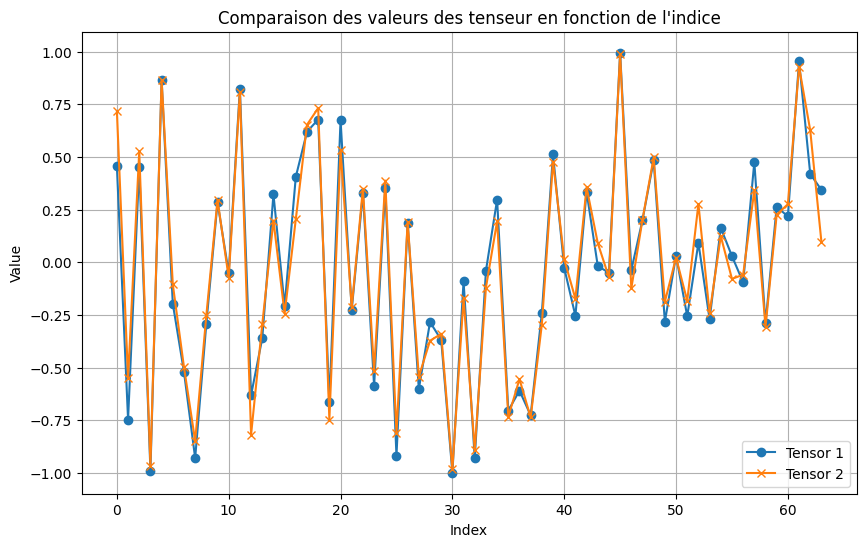

In [16]:
plot_tensors(rnn_hidden[-1].cpu(), tpdn_hidden.cpu())

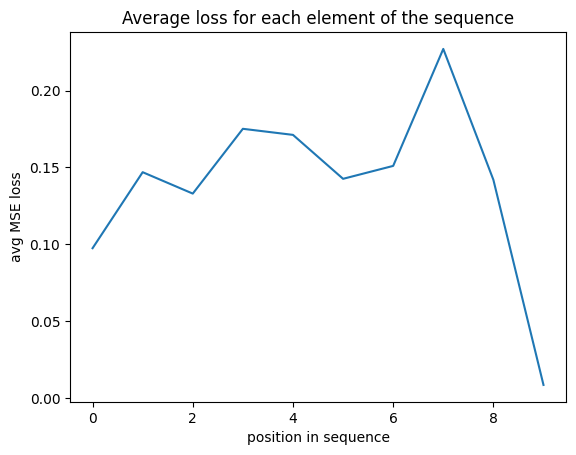

In [17]:
liste_error = []
error = {i : [] for i in range(tpdn_output.shape[1])}
# print( error)
criterion = nn.MSELoss()
for i in range(tpdn_output.shape[1]):
    error[i].append(criterion(tpdn_output[:,i,:].cpu(), rnn_out[:,i,:].cpu()).item())

error_avg  = {k: sum(v) / len(v) for k, v in error.items()}

avg = np.array([v for k, v in error_avg.items()])
plt.plot(avg)
plt.title("Average loss for each element of the sequence")
plt.xlabel("position in sequence")
plt.ylabel("avg MSE loss")
plt.show()

## **Commentaires**

Après modification du tpdn pour bien prendre la somme nous obtenons une loss en évaluation de l'ordre de $10^{-3}$(droite gauche) et $10^{-2}$(gauche droite) ce qui est plus cohérents avec nos expériences précédentes. L'affichage de la courbe moyenne d'erreur en fonction de l'élément de la séquence est lui aussi plus raisonable ( valeures toutes inférieures à 0.4) de plus on observe que la chute particulièrement à chaque fin de séquence, cela peut en partie être dû au au fait que le modèle est appris sur des séquences de taille fixe et que son objectif est de reconstruire la séquence entière et non pas de fournir des états cachés alignés sur ceux du RNN.